# lab4 - Multiword expressions identification and extraction

The task shows two simple methods useful for identifying multiword expressions (MWE) in corpora.

In [1]:
import numpy as np
from pathlib import Path
import string
from typing import Tuple, Dict
from elasticsearch import Elasticsearch
from tqdm import tqdm
import matplotlib.pyplot as plt

## Tasks

1. Compute **bigram** counts in the corpora, ignoring bigrams which contain at least one token that is not a word
   (it contains characters other than letters). The text has to be properly normalized before the counts are computed:
   it should be downcased and all punctuation should be removed. Given the sentence: "The quick borwn fox jumps over the
   lazy dog", the bigram counts are as follows:
   1. "the quick": 1
   1. "quick brown": 1
   1. "brown fox": 1
   1. etc.
   

In [2]:
es = Elasticsearch()
def lemmatize(word: str) -> str:
    analysis = es.indices.analyze(
        "przewie",
        {
            "tokenizer": "standard",
             "filter": ["kodeks_synonym", "lowercase", "morfologik_stem"],
            "text": word
        }
    )
    return analysis["tokens"][0]["token"]
    

In [3]:
def get_bigrams(text: str):
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    return [
        ngram
        for ngram in zip(words[:-1], words[1:]) 
        if all(w.isalpha() for w in ngram)
    ]

In [4]:
bigrams = {}

for file in tqdm(Path("../data/").glob("*.txt")):
    with file.open() as f:
        text = f.read()
    bgrams = get_bigrams(text)
    for bg in bgrams:
        bigrams[bg] = bigrams.get(bg, 0) + 1
bigrams;

1180it [00:23, 50.03it/s]


In [5]:
lem_cache = {}
bigrams_non_lemmatized = bigrams
bigrams_lemmatized = {}

for bgram, count in tqdm(bigrams_non_lemmatized.items()):
    for w in bgram:
        lem_cache[w] = lem_cache.get(w, lemmatize(w))
    lem_bgram = tuple(lem_cache[w] for w in bgram)
    bigrams_lemmatized[lem_bgram] = bigrams_lemmatized.get(lem_bgram, 0) + count 

  2%|▏         | 14788/640189 [00:36<22:40, 459.55it/s]

KeyboardInterrupt: 

In [6]:
bigrams = bigrams_non_lemmatized

words = {}

for ngram, cnt in bigrams.items():
    for w in ngram:
        words[w] = words.get(w, 0) + cnt

2. Use [pointwise mutual information](https://en.wikipedia.org/wiki/Pointwise_mutual_information) to compute the measure 
   for all pairs of words. 
   

In [7]:
def pmi(ngram: Tuple[str, ...], ngrams: Dict[Tuple[str, ...], int], words: Dict[str, int]):
    return np.log((ngrams[ngram] * (len(words) ** len(ngram))) / (np.prod([words[w] for w in ngram]) * ngrams[ngram]))

In [8]:
bgrams_pmis = {
    ngram: pmi(ngram, bigrams, words)
    for ngram in bigrams
}

3. Sort the word pairs according to that measure in the descending order and display 30 top results.

In [9]:
sorted(bgrams_pmis.items(), key=lambda it: it[1])[-30:]

[(('kompatybilność', 'elektromagnetyczna'), 21.875442614536063),
 (('agenci', 'ubezpieczeniowi'), 21.875442614536063),
 (('zołzy', 'strangles'), 21.875442614536063),
 (('waroza', 'varroosis'), 21.875442614536063),
 (('argyreia', 'nervosa'), 21.875442614536063),
 (('dekstromoramid', 'palfium'), 21.875442614536063),
 (('pirolidyna', 'lewotenacylomorfan'), 21.875442614536063),
 (('mppp', 'propionian'), 21.875442614536063),
 (('butylomorfolina', 'racemorfan'), 21.875442614536063),
 (('brolamfetamina', 'dob'), 21.875442614536063),
 (('netylomda', 'mdea'), 21.875442614536063),
 (('etycyklidyna', 'pce'), 21.875442614536063),
 (('psylocybina', 'diwodorofosforan'), 21.875442614536063),
 (('tenamfetamina', 'mda'), 21.875442614536063),
 (('tenocyklidyna', 'tcp'), 21.875442614536063),
 (('młody', 'naukowiec'), 21.875442614536063),
 (('benzol', 'benzen'), 21.875442614536063),
 (('toluol', 'toluen'), 21.875442614536063),
 (('ksylol', 'ksyleny'), 21.875442614536063),
 (('chronicznej', 'bezsenności'),

4. Use [log likelihood ratio](http://tdunning.blogspot.com/2008/03/surprise-and-coincidence.html) (LLR) to compute the measure for all pairs of words.

In [10]:
def H(k: np.ndarray):
    N = k.sum()
    return (
        (k / N) * np.log(k / N + 1e-7)
    ).sum()

def LLR(k: np.ndarray):
    return (2 * k.sum()) * (
        H(k) - 
        H(k.sum(axis=0)) - 
        H(k.sum(axis=1))
    )

In [11]:
all_ngrams = np.sum(list(bigrams.values()))

def incidence(bigram: Tuple[str, str], ngrams: Dict[Tuple[str, str], int], words: Dict[str, int]) -> np.ndarray:
    w1, w2 = bigram
    w1_w2 = ngrams.get((w1, w2), 0)
    w1_not_w2 = words[w1] - w1_w2
    w2_not_w1 = words[w2] - w1_w2
    not_w1_not_w2 = all_ngrams - w1_not_w2 - w1_not_w2 - w1_w2
    return np.array([
        [w1_w2, w1_not_w2],
        [w2_not_w1, not_w1_not_w2]
    ])

In [12]:
bgrams_llrs = {
    ngram: LLR(incidence(ngram, bigrams, words))
    for ngram in bigrams
}

5. Sort the word pairs according to that measure in the descending order and display 30 top results.

In [13]:
sorted(bgrams_llrs.items(), key=lambda it: it[1])[-30:][::-1]

[(('r', 'nr'), 134012.18830984252),
 (('otrzymuje', 'brzmienie'), 106997.36017188063),
 (('w', 'w'), 91893.71067912418),
 (('których', 'mowa'), 67468.79360747724),
 (('mowa', 'w'), 57241.62809136362),
 (('w', 'ust'), 55088.89948920093),
 (('w', 'art'), 46277.94340040706),
 (('dodaje', 'się'), 45070.638207469456),
 (('którym', 'mowa'), 44034.65025962541),
 (('o', 'których'), 43274.75960586615),
 (('minister', 'właściwy'), 39045.33186066236),
 (('drodze', 'rozporządzenia'), 38645.14129208478),
 (('w', 'i'), 38623.81711701967),
 (('w', 'z'), 35071.16296182343),
 (('w', 'o'), 34645.317249131345),
 (('stosuje', 'się'), 32902.13860616883),
 (('rzeczypospolitej', 'polskiej'), 32822.212510543606),
 (('do', 'spraw'), 31120.05528889166),
 (('w', 'do'), 31081.6218271927),
 (('z', 'w'), 29960.436758928223),
 (('z', 'dnia'), 29675.016779344147),
 (('o', 'w'), 29421.730265136903),
 (('o', 'którym'), 28352.39772989688),
 (('na', 'podstawie'), 27965.359295005746),
 (('w', 'na'), 26660.2181144531),
 ((

In [14]:
np.mean(list(bgrams_llrs.values()))

26.008407292671116

/home/mprzewie/.anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/home/mprzewie/.anaconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/mprzewie/.anaconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


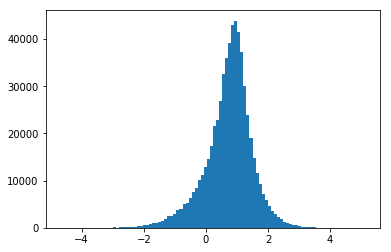

In [15]:
plt.hist(np.log10(list(bgrams_llrs.values())), bins=100)
plt.show()

In [17]:
[(k,v) for (k, v) in bgrams_llrs.items() if v > 26][:20]

[(('tekst', 'ustawy'), 2437.4300756196913),
 (('ustawy', 'przekazany'), 133.97692963909873),
 (('przekazany', 'do'), 77.88867348877669),
 (('do', 'senatu'), 73.3570682007736),
 (('senatu', 'zgodnie'), 97.2403712746118),
 (('zgodnie', 'z'), 9650.794779644017),
 (('z', 'art'), 2444.187249360115),
 (('regulaminu', 'sejmu'), 216.9060854501238),
 (('sejmu', 'ustawa'), 69.78098319158488),
 (('ustawa', 'z'), 2965.198374009075),
 (('z', 'dnia'), 29675.016779344147),
 (('r', 'o'), 14497.245206481473),
 (('o', 'zmianie'), 4225.0863874703955),
 (('zmianie', 'ustawy'), 4913.05607901784),
 (('ustawy', 'o'), 1610.811810404208),
 (('niektórych', 'emerytów'), 60.724174486204184),
 (('emerytów', 'rencistów'), 141.85410201641997),
 (('i', 'osób'), 468.3231857641318),
 (('osób', 'pobierających'), 369.3707730226997),
 (('pobierających', 'świadczenie'), 89.88968399594502)]

6. Answer the following questions:
   
### Which measure works better for the problem?

LLR, as it takes into account not only how often this combination of words occurs together as opposed to those words separately and how often it occurs as opposed to other combinations.

### What would be needed, besides good measure, to build a dictionary of multiword expressions?

A lot of computational power and memory. Also, a good lemmatizer.

### Can you identify a certain threshold which clearly divides the *good* expressions from the *bad*?

I'd go for the mean LLR, which is about 26.

## Hints

1. An n-gram is a sequence containing n words. A unigram is a sequence containing one word,
   a bigram is a sequence containing two words, etc.
1. Pointwise mutual information is used to identify correlated events. It's based on the assumption that the events
   follow normal distribution and that there is a minimal number of occurrences of the words. These assumptions hold
   only for a subset of words.
1. Log likelihood ratio test doesn't have these assumption. This makes it better suited for the task.
1. There is [LLR implementation](https://github.com/tdunning/python-llr) in Python, implemented by Ted Dunning - the
   author of the important work [Accurate Methods for the Statistics of Surprise and
   Coincidence](https://aclweb.org/anthology/J93-1003) which introduces LLR to NLP.
1. The methods presented in this exercise can be also used for the identification of words belonging to a given domain
   (e.g. law, biology, medicine).
1. [SRI LM](http://www.speech.sri.com/projects/srilm/) is useful for computing the counts of n-grams.
1. ElasticSearch has a [shingle token filter](https://www.elastic.co/guide/en/elasticsearch/reference/current/analysis-shingle-tokenfilter.html) 
   which can be used to build the n-grams as well.
1. More sophisticated algorithms for multiword expressions identification, such as 
   [AutoPhrase](https://github.com/shangjingbo1226/AutoPhrase) take into account more features including:
   morphosyntactic tags, expression contexts, etc. and use data from e.g. Wikipedia, to automatically identify
   high-quality multiword expressions and use them to train MWE classifiers.
1. BTW "multiword expressions" is a mutliword expression itself ;-)